In [1]:
import emcee
import numpy as np

import corner
from matplotlib import pyplot as plt
from scipy import optimize

from cr_knee_fit.inference import (
    initial_guess_model,
    make_loglikelihood,
    make_logposterior,
)
from cr_knee_fit.model import Model, ModelConfig
from cr_knee_fit.types_ import Experiment, Primary
from cr_knee_fit.fit_data import FitData

In [2]:
# PRIMARIES = [Primary.H, Primary.He]
# EXPERIMENTS = [Experiment.AMS02, Experiment.DAMPE, Experiment.GRAPES]

PRIMARIES = list(Primary)
EXPERIMENTS = list(Experiment)

R_BOUNDS = (7e2, 1e8)  # GV

In [3]:
from cr_knee_fit.cr_model import CosmicRaysModelConfig


fit_data = FitData.load(EXPERIMENTS, PRIMARIES, R_BOUNDS)
config = ModelConfig(
    cr_model_config=CosmicRaysModelConfig(
        primaries=PRIMARIES,
        n_breaks=2,
    ),
    shifted_experiments=[e for e in EXPERIMENTS if e is not Experiment.AMS02],
)

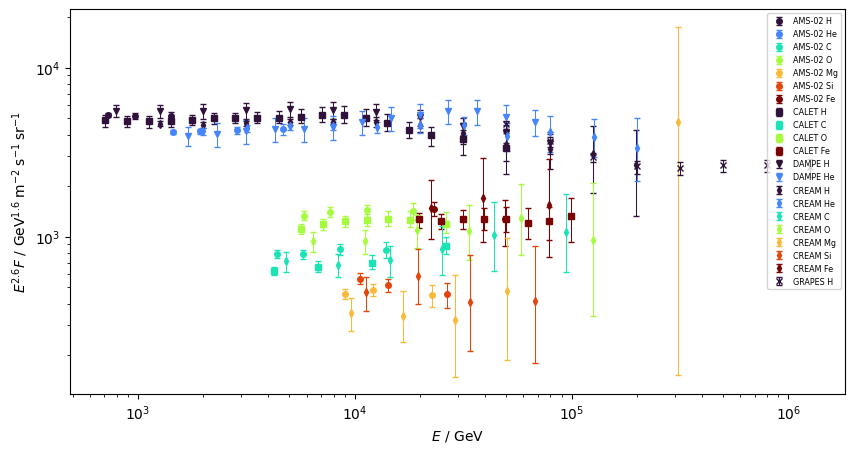

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))

for _, p_data in fit_data.spectra.items():
    for _, data in p_data.items():
        data.plot(scale=2.6, ax=ax)

ax.legend(fontsize="xx-small")
ax.set_xscale("log")
ax.set_yscale("log")

## Pre-optimization


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 45.499814272414895
             x: [-4.101e+00  2.616e+00 ... -2.700e-01  6.425e-01]
           nit: 6100
          nfev: 7791
 final_simplex: (array([[-4.101e+00,  2.616e+00, ..., -2.700e-01,
                         6.425e-01],
                       [-4.101e+00,  2.616e+00, ..., -2.700e-01,
                         6.425e-01],
                       ...,
                       [-4.101e+00,  2.616e+00, ..., -2.700e-01,
                         6.425e-01],
                       [-4.101e+00,  2.616e+00, ..., -2.700e-01,
                         6.425e-01]]), array([ 4.550e+01,  4.550e+01, ...,  4.550e+01,  4.550e+01]))
lg(I) (H) = -4.10e+00
alpha (H) = 2.62e+00
lg(I) (He) = -4.96e+00
alpha (He) = 2.54e+00
lg(I) (C) = -6.96e+00
alpha (C) = 2.48e+00
lg(I) (O) = -7.06e+00
alpha (O) = 2.54e+00
lg(I) (Mg) = -7.95e+00
alpha (Mg) = 2.51e+00
lg(I) (Si) = -8.06e+00
alpha (Si) = 2.81e+00

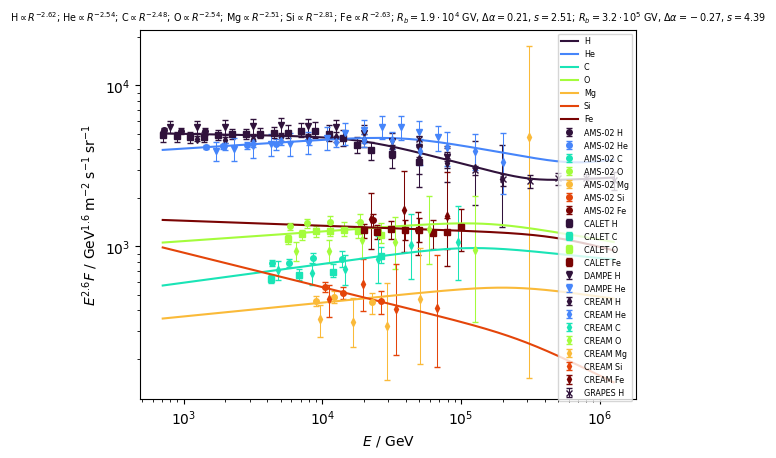

In [8]:
import dataclasses


pre_optimization_config = dataclasses.replace(config, shifted_experiments={})
loglike = make_loglikelihood(fit_data, pre_optimization_config)


def minimized_fn(v: np.ndarray) -> float:
    return -loglike(v)


res = optimize.minimize(
    minimized_fn,
    x0=initial_guess_model(pre_optimization_config).pack(),
    method="Nelder-Mead",
    options={
        "maxiter": 100_000,
    },
)
print(res)

mle_model = Model.unpack(res.x, layout_info=pre_optimization_config)
mle_model.plot(fit_data, scale=2.6)
print(mle_model.format_params())

In [9]:
init_model = initial_guess_model(config)

In [12]:
n_steps = 10_000
n_walkers = 128
n_dim = init_model.ndim()

sampler = emcee.EnsembleSampler(
    nwalkers=n_walkers,
    ndim=n_dim,
    log_prob_fn=make_logposterior(fit_data, config),
)
initial_state = np.array([initial_guess_model(config).pack() for _ in range(n_walkers)])
sampler.run_mcmc(initial_state, nsteps=n_steps, progress=True)
print(f"Acceptance fraction: {sampler.acceptance_fraction.mean()}")

tau = sampler.get_autocorr_time(quiet=True)
print(f"{tau = }")

burn_in = 5 * int(tau.max())
thin = 2 * int(tau.max())

print(f"{burn_in = } {thin = }")

theta_sample: np.ndarray = sampler.get_chain(flat=True, discard=burn_in, thin=thin)  # type: ignore
print(f"MCMC sample ready, shape: {theta_sample.shape}")

100%|██████████| 10000/10000 [16:38<00:00, 10.02it/s]


Acceptance fraction: 0.26234999999999997


The chain is shorter than 50 times the integrated autocorrelation time for 17 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [165.88575498 289.66384764  81.48692253 317.64393085  48.56149978
 490.77789078  77.1661903  353.36811687 144.00864304 326.32170506
  76.52791585 318.1816253  148.28966132 309.35692385 425.28112668
 431.74769893 344.57324856 403.34709876 389.31715985 359.62895686
 479.36170214 285.3180458  418.51465137 388.08190952]


tau = array([165.88575498, 289.66384764,  81.48692253, 317.64393085,
        48.56149978, 490.77789078,  77.1661903 , 353.36811687,
       144.00864304, 326.32170506,  76.52791585, 318.1816253 ,
       148.28966132, 309.35692385, 425.28112668, 431.74769893,
       344.57324856, 403.34709876, 389.31715985, 359.62895686,
       479.36170214, 285.3180458 , 418.51465137, 388.08190952])
burn_in = 2450 thin = 980
MCMC sample ready, shape: (896, 24)


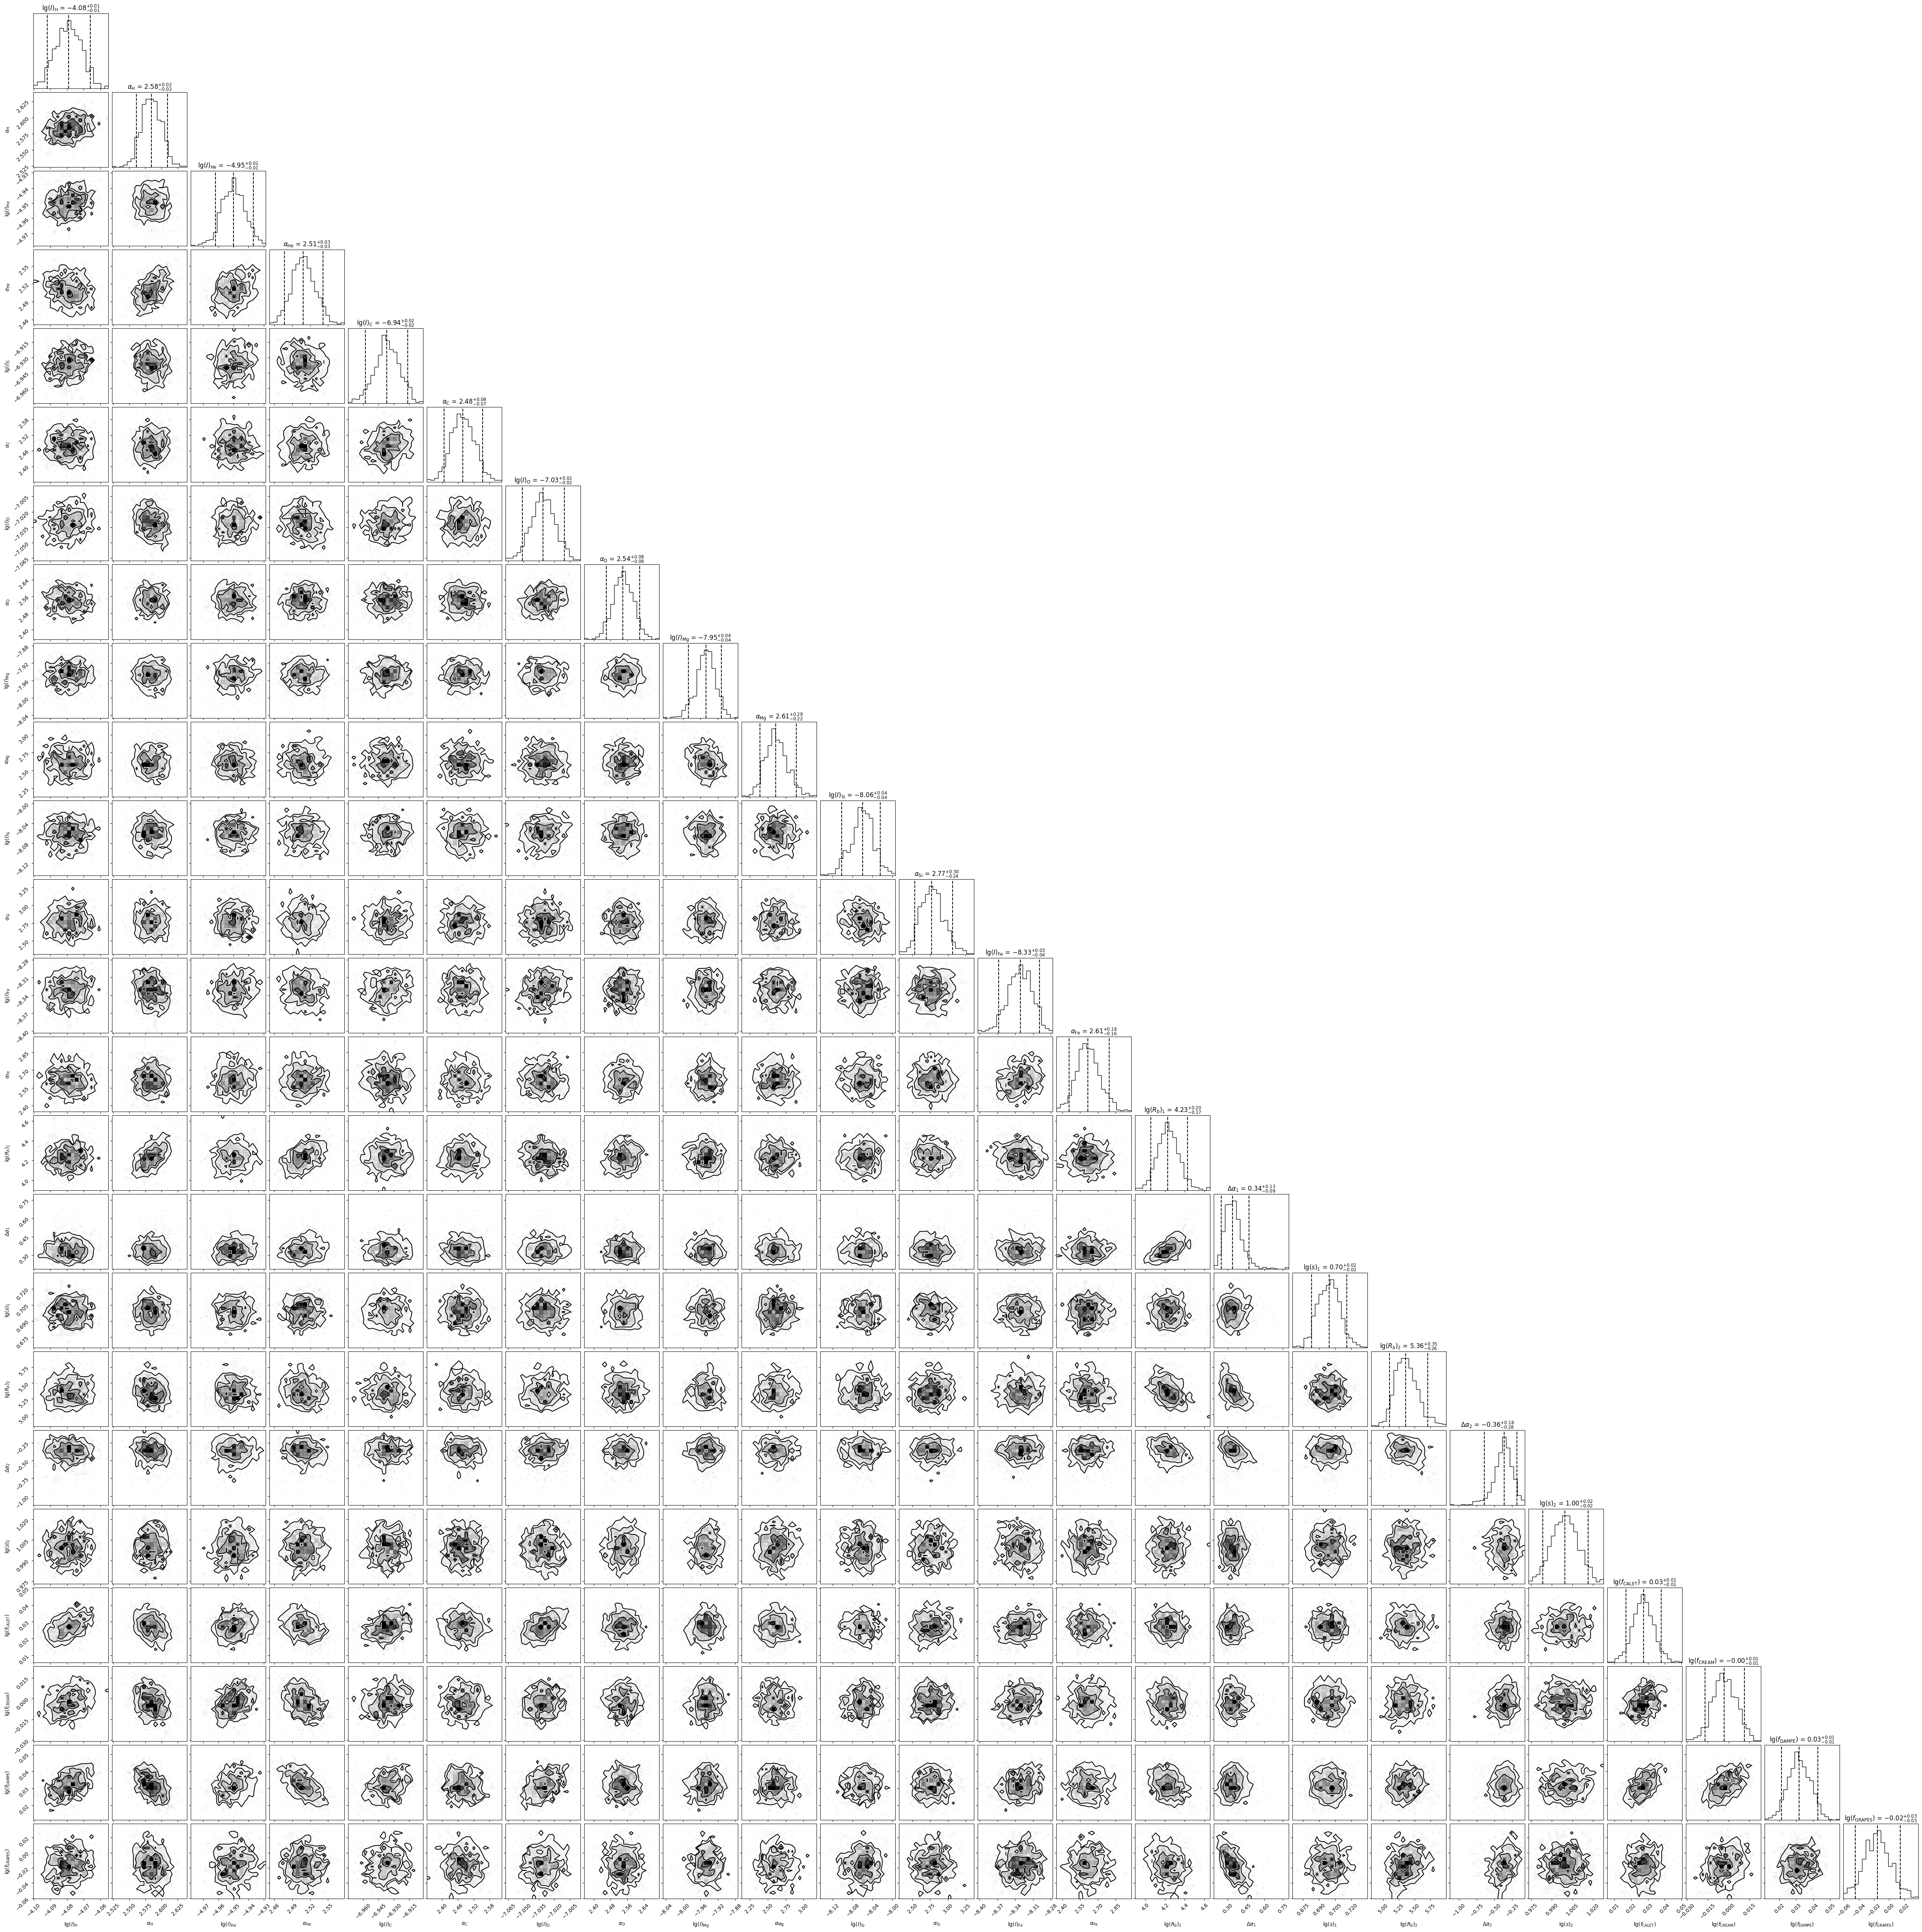

In [13]:

sample_to_plot = theta_sample
sample_labels = ["$" + label + "$" for label in init_model.labels(True)]

_ = corner.corner(
    sample_to_plot,
    labels=sample_labels,
    show_titles=True,
    quantiles=[0.05, 0.5, 0.95],
)

(np.float64(334.8609921184278), np.float64(2663278.2587127783))

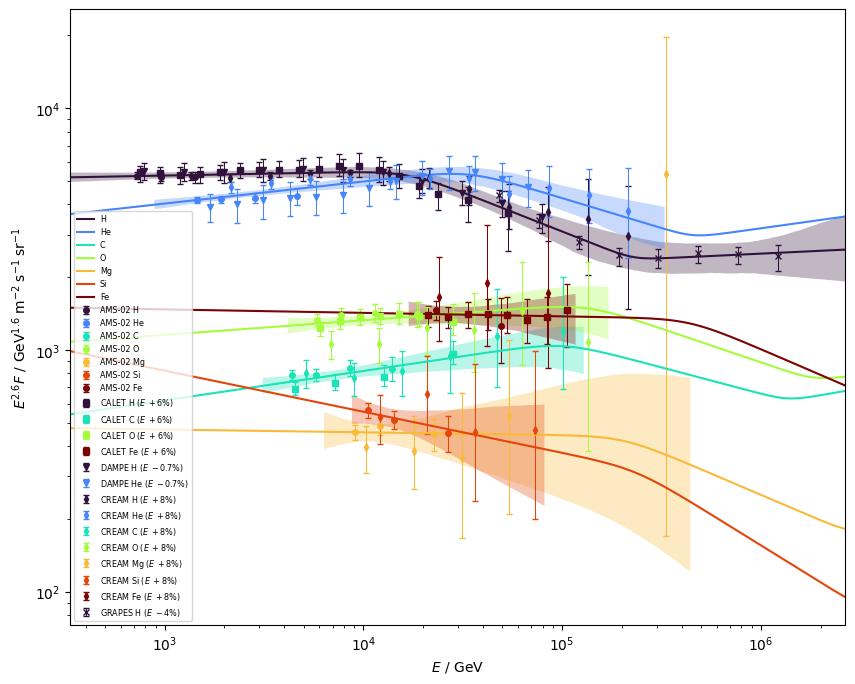

In [16]:
import itertools

from cr_knee_fit.utils import add_log_margin


scale = 2.6
model_sample = [Model.unpack(theta, layout_info=config) for theta in theta_sample]
median_model = Model.unpack(np.median(theta_sample, axis=0), layout_info=config)

fig, ax = plt.subplots(figsize=(10, 8))

for exp, data_by_particle in fit_data.spectra.items():
    for _, data in data_by_particle.items():
        data.with_shifted_energy_scale(f=median_model.energy_shifts.f(exp)).plot(scale=scale, ax=ax)

primaries = list(median_model.cr_model.components.keys())
Emin, Emax = add_log_margin(fit_data.E_min(), fit_data.E_max())
median_model.cr_model.plot(Emin, Emax, scale=scale, axes=ax)

for p in primaries:
    primary_energies = list(
        itertools.chain.from_iterable(
            exp_spectra[p].E for exp_spectra in fit_data.spectra.values() if p in exp_spectra
        )
    )
    Emin_p, Emax_p = add_log_margin(min(primary_energies), max(primary_energies))
    E_grid = np.logspace(np.log10(Emin_p), np.log10(Emax_p), 300)
    E_factor = E_grid**scale
    upper = []
    lower = []
    for E in E_grid:
        predictions = np.array([model.cr_model.compute(E, p) for model in model_sample])
        lower.append(np.quantile(predictions, q=0.05))
        upper.append(np.quantile(predictions, q=0.95))
    ax.fill_between(
        E_grid,
        E_factor * lower,
        E_factor * upper,
        color=p.color,
        alpha=0.3,
        edgecolor="none",
    )

ax.legend(fontsize="xx-small")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(Emin, Emax)
